# 4. Howto SkewT-LogP

In this notebook, we will explore all the applications of a Skew-T Log-P diagram that you will need for the final exam.

```{admonition} We will cover:
1. [The diagram's isolines](sec:isolines)
2. [How to find basic meteorological quantities](sec:meteo-variables)
3. [How to determine moist adiabatic quantities that we use in simple cloud models](sec:moist-adiabatic)
4. [How to analyse and quantify stability and potential for (moist) convection](sec:stability)
5. [How to perform calculations involving lifting, diabatic processes, and subsequent descent](sec:ascent-descent)
```

In short, this is the course's Howto SkewT-logP manual!

The notebook builds on an honours project by Shu Wen Puah; she deserves much of the credit.

(sec:isolines)=
## The lines in the Skew T-log P diagram

In [1]:
from metpy.plots import SkewT
from metpy.units import units
from IPython.display import display, clear_output
from metpy.calc import saturation_mixing_ratio 
from metpy.calc import mixing_ratio
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import ipywidgets as widgets

Let us first cover the spaghetti of lines in the diagram. Open up the code cell below if you wish to see how to define these lines.

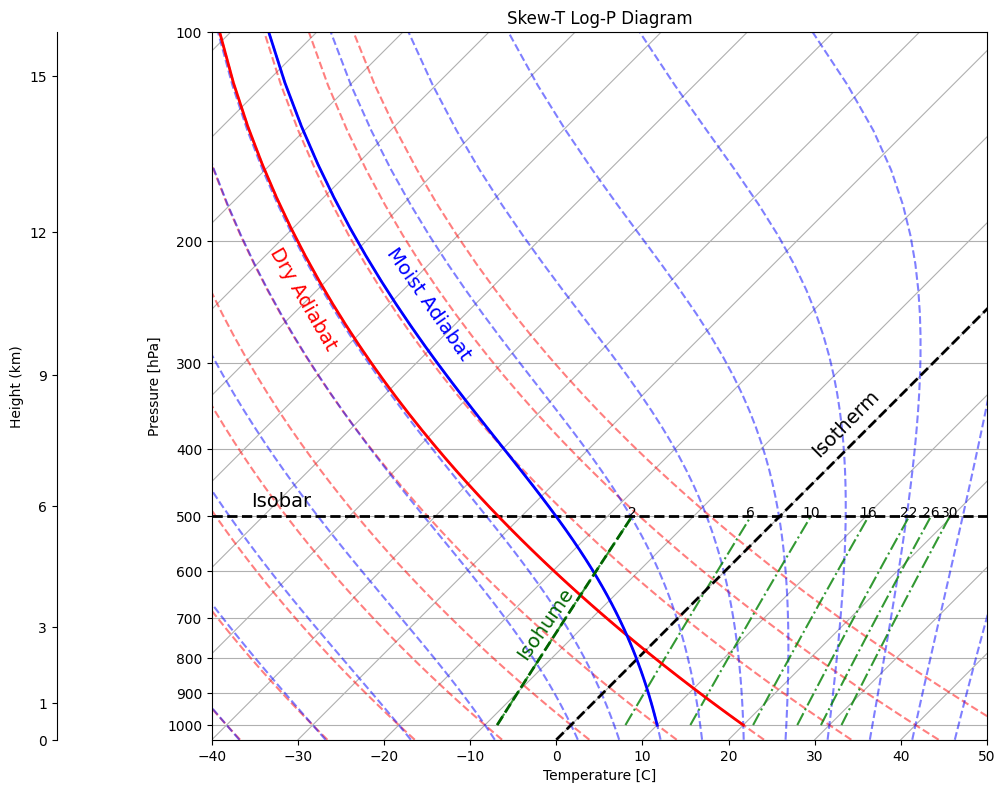

In [336]:
# Function to make a basic skew T - log p plot
def plot_basic_skewt():
    # Basic Skew T - log p diagram
    fig = plt.figure()
    skew = SkewT(fig, rotation=45)
    
    # Add dry and moist adiabats
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    
    # Add isohumes at specified mixing ratios
    w = np.array([0.03, 0.026, 0.022, 0.016, 0.01, 0.006, 0.002])[:, None] * units('g/g')
    p = units.hPa * np.linspace(1000, 500, 7)
    skew.plot_mixing_lines(mixing_ratio=w, pressure=p, color='darkseagreen', linestyle='-.')

    # Label the isohumes
    for val in w.flatten():
        top_p = p[-1]
        dewpt = mpcalc.dewpoint(mpcalc.vapor_pressure(top_p, val))
        skew.ax.text(dewpt, top_p, str(int(val.to('g/kg').m)),
                     horizontalalignment='center')
    
    # Add a secondary y-axis using the standard atmosphere, so we can see height as well as pressure
    secax = skew.ax.secondary_yaxis(-0.2,
        functions=(
            lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
            lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
        )
    )
    secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
    secax.yaxis.set_minor_locator(plt.NullLocator())
    secax.yaxis.set_major_formatter(plt.ScalarFormatter())

    # Add labels
    skew.ax.set_xlabel('Temperature [C]')
    skew.ax.set_ylabel('Pressure [hPa]')
    plt.title ('Skew-T Log-P Diagram')
    secax.set_ylabel('Height (km)')

    # Make it big
    fig.set_size_inches(10,10)

    return skew

# Make the plot
skew = plot_basic_skewt()

# Highlight specific lines
# Isotherm
skew.ax.axvline(x=0, c='black', linestyle='--', linewidth=2)
skew.ax.text(0.77, 0.5, r'Isotherm', fontsize=14,
             transform=skew.ax.transAxes, rotation=45, verticalalignment='top', c='black')

# Isobar
skew.ax.axhline(y=500, c='black', linestyle='--', linewidth=2)
skew.ax.text(0.05, 0.35, r'Isobar', fontsize=14,
             transform=skew.ax.transAxes, verticalalignment='top', c='black')

# Dry adiabat
p = np.linspace(1000, 100, 50) * units.hPa
T_dry = mpcalc.dry_lapse(p, 20 * units.degC)
skew.ax.plot(T_dry, p, c='red', linewidth=2)
skew.ax.text(0.07, 0.7, r'Dry Adiabat', fontsize=14,
             transform=skew.ax.transAxes, rotation=-60, verticalalignment='top', c='red')

# Moist adiabat
T_moist = mpcalc.moist_lapse(p, 10 * units.degC)
skew.ax.plot(T_moist, p, c='blue', linewidth=2)
skew.ax.text(0.22, 0.7, r'Moist Adiabat', fontsize=14,
             transform=skew.ax.transAxes, rotation=-55, verticalalignment='top', c='blue')

# Isohume
p = units.hPa * np.linspace(1000, 500, 7)
highlight_w = 0.002 * units('g/g')
e = mpcalc.vapor_pressure(p, highlight_w)  
T_mixing = mpcalc.dewpoint(e)  
skew.ax.plot(T_mixing, p, color='darkgreen', linestyle='--', linewidth=2)
_ = skew.ax.text(0.39, 0.22, r'Isohume', fontsize=14,
                 transform=skew.ax.transAxes, rotation=55, verticalalignment='top', c='darkgreen')

We have plotted:

1. Isobars: The horizontal lines with constant pressure.
2. Isotherms: The grey, "skewed" grid-lines (set to rise up and right at a 45 degree angle), with equal temperature.
3. Dry Adiabats:  The red curved lines with constant potential temperature $\theta$ (see [Thermodynamics (i)](2.%20Thermodynamics%20(i).ipynb)). They represent the temperatures of dry air parcels lifted or lowered adiabatically to the 1000 hPa level.
4. Moist Adiabats: The blue curved lines with constant equivalent potential temperature $\theta_e$, with a mixing ratio $r_v$ kept equal to the saturation mixing ratio ($r_s$) at a given pressure and temperature (see [Thermodynamics (ii)](3.%20Thermodynamics%20(ii).ipynb)).
5. Isohumes: The green, "skewed" lines rising up and right (but more vertically than the isotherm), with constant mixing ratio $r_v$. The lines really show the dew-point temperature of a parcel with a prescribed mixing ratio, as the pressure drops (see [Thermodynamics (ii)](3.%20Thermodynamics%20(ii).ipynb)).

(sec:meteo-variables)=
## Identifying meteorological variables

We now add a sounding to the diagram, and start by reading off some basic variables, at a selected pressure level.

In [6]:
# Open a sounding
ds = xr.open_dataset('data/valencia.nc').isel(latitude=0,longitude=0).sel(valid_time='2024-10-29T15:00:00.000000000')

Rd = 287.05
Rv = 461.5 # J/kg/K, gas constant of water
lv_trip = 2500e3 # J/kg, latent heat of vaporisation at the triple point of water
T_trip = 273.15 # K, Temperature for triple point of water at 1000 hPa air pressure
es_trip = 610.94 # Pa, equilibrium vapour pressure at triple point of water

def Tdew(e):
    return (1/T_trip - Rv/lv_trip*np.log(e/es_trip))**(-1)
def e_sq(qs, p):
    return qs * p / (qs * (1-Rd/Rv) + Rd/Rv)


ds['tdew'] = mpcalc.dewpoint(mpcalc.vapor_pressure(ds.pressure_level*100, ds.q))
ds['tdew'] = Tdew(e_sq(ds.q, ds.pressure_level*100))

# To increase the width at the bottom of the original soundings for construction visualisation.
ds['t'].loc[ds.pressure_level > 900] += 1.5
ds['tdew'].loc[ds.pressure_level > 900] -= 2

### 1. Temperature
Let us first find the temperature in the atmosphere at 700hPa. To do that, take the following steps:

1. Draw a horizontal line at 700 hPa. Find its intersection with the temperature sounding.
2. Draw a line parallel to the skewed isotherms from point 1 back down to the x-axis. Read off the temperature: It is 1.8°C.

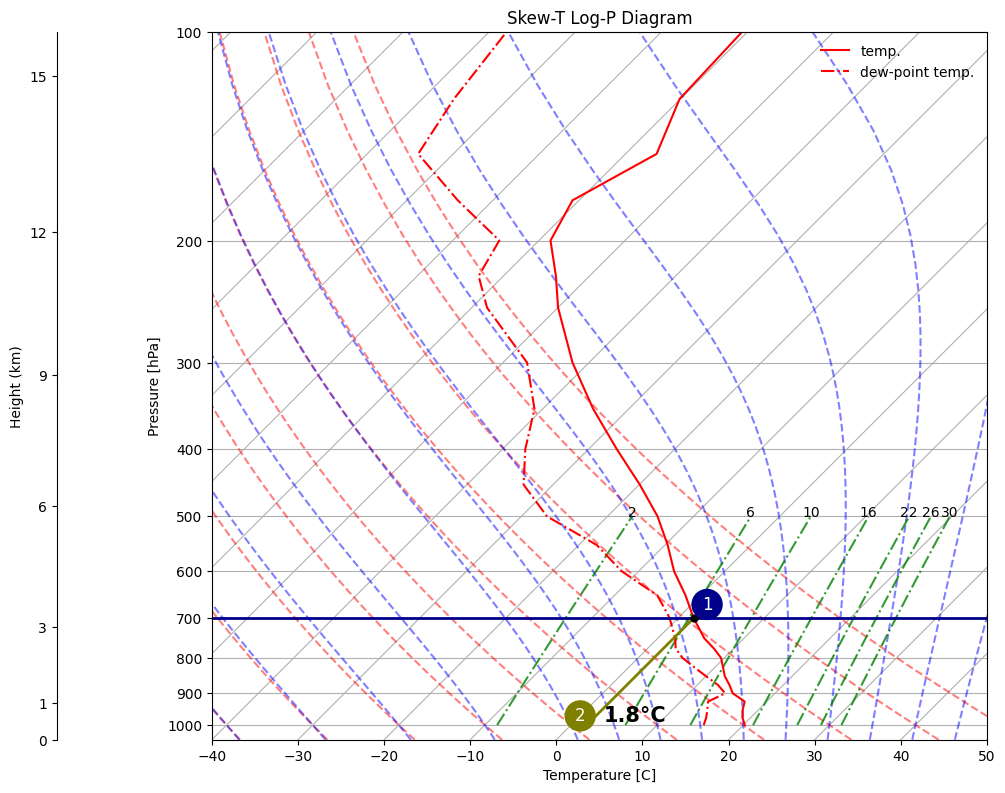

In [5]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Draw the horizontal line at 700 hPa
skew.ax.axhline(y=700, c='darkblue', linestyle='-', linewidth=2)

# Get the temperature sounding data
temp_sounding = (ds.t - 273.15).values  
pressure_levels = ds.pressure_level.values  

# Ensure pressure levels are sorted in descending order 
sorted_indices = np.argsort(pressure_levels)[::-1]
pressure_sorted = pressure_levels[sorted_indices]
temp_sorted = temp_sounding[sorted_indices]

# Step 1: Find the two surrounding points for 700 hPa
above_idx = np.where(pressure_sorted > 700)[0][-1]  # Last index where pressure > 700
below_idx = np.where(pressure_sorted < 700)[0][0]  # First index where pressure < 700

p1, t1 = pressure_sorted[above_idx], temp_sorted[above_idx]
p2, t2 = pressure_sorted[below_idx], temp_sorted[below_idx]

# Step 2: Linear interpolation to find dew point at 700 hPa
intersection_temp = t1 + (t2 - t1) * ((700 - p1) / (p2 - p1))

# Step 3: Draw a vertical line following the isotherm down to the x-axis 
skew.ax.plot([intersection_temp, intersection_temp], [700, 1000], 
             c='olive', linestyle='-', linewidth=2)

# Step 4: Label the temperature found at the intersection
skew.ax.text(intersection_temp + 2, 1000, f'{intersection_temp:.1f}°C',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Step 5: Mark the intersection point at 700 hPa
skew.ax.plot(intersection_temp, 700, marker='o', markersize=5, color='black')

# Steps labeling 
plt.text(1.8, 670, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(0, 970, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))

### 2. Dew Point Temperature
Let us next determine the dew point temperature at 700hPa:

1. Draw a horizontal line at 700 hPa. Find its intersection with the *dew point temperature* sounding.
2. Draw a line parallel to the skewed isotherms from point 1. back down to the x-axis. Read off the temperature: It is -1.0°C.

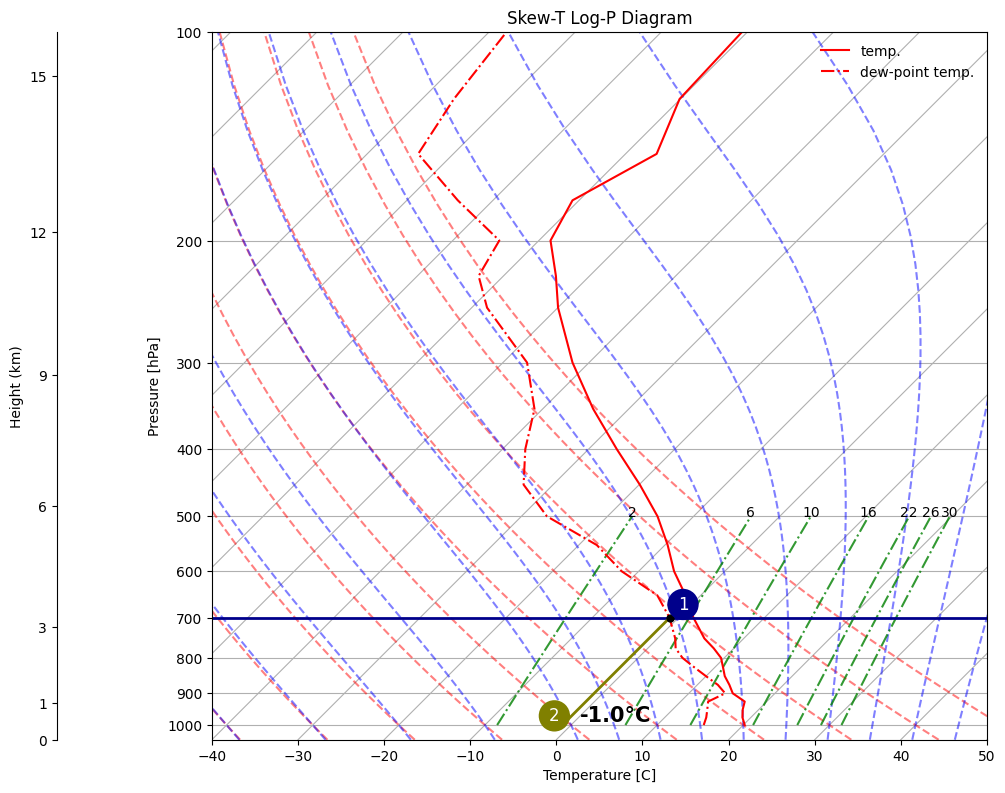

In [7]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Draw the horizontal line at 700 hPa
skew.ax.axhline(y=700, c='darkblue', linestyle='-', linewidth=2)

# Get the temperature sounding data
dew_point_sounding = (ds.tdew - 273.15).values  
pressure_levels = ds.pressure_level.values  

# Ensure pressure levels are sorted in descending order (high to low)
sorted_indices = np.argsort(pressure_levels)[::-1]
pressure_sorted = pressure_levels[sorted_indices]
dew_point_sorted = dew_point_sounding[sorted_indices]

# Step 1: Find the two surrounding points for 700 hPa
above_idx = np.where(pressure_sorted > 700)[0][-1]  
below_idx = np.where(pressure_sorted < 700)[0][0]  

p1, t1 = pressure_sorted[above_idx], dew_point_sorted[above_idx]
p2, t2 = pressure_sorted[below_idx], dew_point_sorted[below_idx]

# Step 2: Linear interpolation to find dew point at 700 hPa
intersection_dew_point = t1 + (t2 - t1) * ((700 - p1) / (p2 - p1))

# Step 3: Draw a vertical line following the isotherm (constant temperature) down to the x-axis (1000 hPa)
skew.ax.plot([intersection_dew_point, intersection_dew_point], [700, 1000], 
             c='olive', linestyle='-', linewidth=2)

# Step 4: Label the temperature found at the intersection
skew.ax.text(intersection_dew_point + 2, 1000, f'{intersection_dew_point:.1f}°C',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Step 5: Mark the intersection point at 700 hPa
skew.ax.plot(intersection_dew_point, 700, marker='o', markersize=5, color='black')

# Steps labeling 
plt.text(-1, 670, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(-3, 970, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))

### 3. Potential Temperature

The potential temperature of an air parcel is the temperature that it would have if it were dry, and compressed (or expanded) adiabatically from its current pressure and temperature to a standard pressure (1000hPa). Since this is exactly what moving along a dry adiabat represents, we simply have to:

1. Again draw a horizontal line at 700 hPa and find its intersection with the temperature sounding.
2. Draw a line of constant potential temperature (equivalently, a dry adiabat) through this intersection, and follow it down to the 1000 hPa standard pressure.
3. Follow the isotherm from this point, to the x-axis, and read off the value: 31.2°C.

Note that this value is much larger than the temperature at 700 hPa (which was 1.8°C), because compressing the air parcel from 700 hPa to 1000 hPa warms it up substantially.

Because intersection points we want to know the potential temperature at hardly ever line up perfectly with a provided dry adiabat, you will have to draw as parallel to the dry adiabats on the diagram as you can. We won't penalise drawing errors here, so long as it is clear you are following the right procedure.

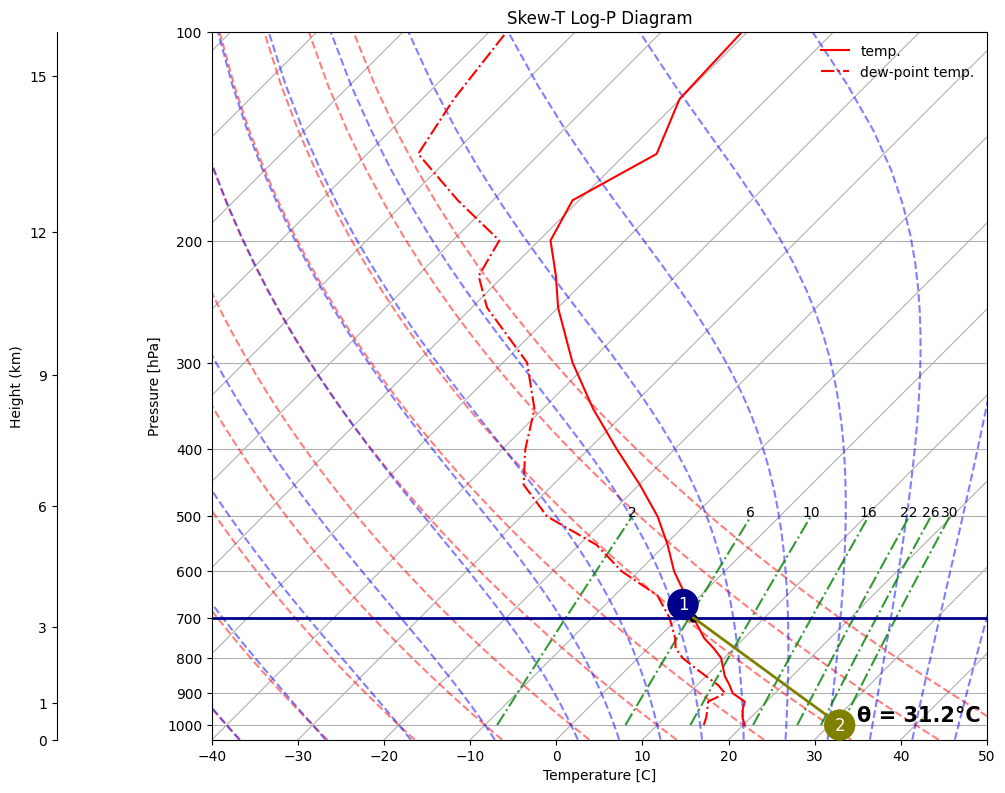

In [11]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Draw the horizontal line at 700 hPa
skew.ax.axhline(y=700, c='darkblue', linestyle='-', linewidth=2)

# Get the temperature at 700 hPa and convert to °C
temp_700 = ds.t.sel(pressure_level=700).values - 273.15  # Convert from K to °C

# Plot the point at the intersection
skew.ax.plot(temp_700, 700, marker='o', markersize=5, color='black')

# Draw a dry adiabat from the intersection to the x-axis
dry_adiabat = mpcalc.dry_lapse(units.Quantity([700, 1000], 'hPa'), 
                               units.Quantity(temp_700 + 273.15, 'K'))  # Convert back to K for calculation
dry_adiabat_celsius = dry_adiabat.to('degC').m  # Convert to °C

# Plot the dry adiabat line
skew.ax.plot(dry_adiabat_celsius, [700, 1000], color='olive', linestyle='-', linewidth=2)

# Label the potential temperature at 700 hPa
theta_700 = mpcalc.potential_temperature(units.Quantity(700, 'hPa'), 
                                         units.Quantity(temp_700 + 273.15, 'K')).to('degC').m
skew.ax.text(dry_adiabat_celsius[-1]+2, 1000, f'θ = {theta_700:.1f}°C',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Steps labeling 
plt.text(-1, 670, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(31.2, 1000, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))

(sec:mixing-ratio)=
### 4. Mixing Ratio

Let us next find the mixing ratio of the sounding at 700 hPa. We essentially measure mixing ratio in a SkewT-logP plot with the dew-point temperature. This is because, at a given pressure $p$ and dew-point temperature $T_d$ (i.e. a coordinate point on the diagram), we can determine the mixing ratio, since (see [Thermodynamics (ii)](3.%20Thermodynamics%20(ii).ipynb) for origin of the equations):
1. We can solve an approximation of the integrated Clausius-Clapeyron equation (e.g. Tetens' formula) using the known $T_d$, which will give us the equilibrium (or saturation) vapour pressure $e_s$:
   
$$
  e_s(T_d) = 610.94 \times \exp\left(17.625\times\frac{T_d - 273.15}{T_d - 30.11}\right)
$$

2. At saturation, by definition the saturation vapour $e_s$ pressure equals the actual vapour pressure $e$, so we actually know also this vapour pressure.
3. We can relate the vapour pressure to the mixing ratio $r_v$, with the known pressure $p$:
   
$$
r_v = \frac{R_d}{R_v}\frac{e}{p - e}.
$$

In this last equation, if we plug in the expression $e_s(T_d)$ and solve it for $p$, we get an expression for $p$ only in terms of $T_d$ and $r_v$. So for a fixed $r_v$, we can trace lines through the skewT-logP diagram: The isohumes are exactly these lines. It may feel a bit convoluted to express a mixing ratio in terms of a dew-point temperature like this. But it has the advantage of enabling us to plot that mixing ratio in a diagram whose axes are pressure and temperature, so it turns out to be very useful! E.g., to find out the mixing ratio of the sounding at any pressure, all we have to do is intersect the dew-point temperature of the sounding with an isohume, and read off the mixing ratio that is constant along that isohume (this mixing ratio will always be written out on the plot). I.e., the saturation mixing ratio at 700 hPa is determined as follows:

1. Draw a horizontal line at 700 hPa. Find its intersection with the dew point temperature sounding.
2. Draw a line parallel to the isohume from this intersection. Read off the saturation mixing ratio. You may need to mentally interpolate between adjacent lines; we will not penalise you for slightly wrong answers here, so long as you follow the right procedure.

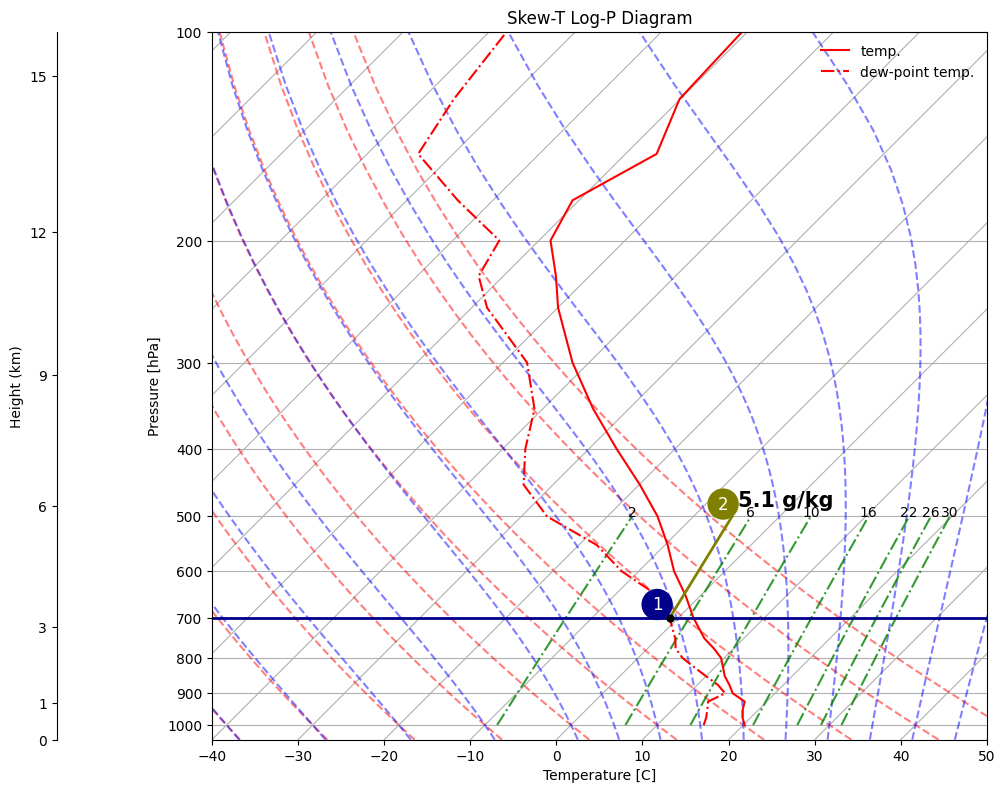

In [14]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Draw the horizontal line at 700 hPa
skew.ax.axhline(y=700, c='darkblue', linestyle='-', linewidth=2)

# Step 1: Find the intersection between the dew point temperature sounding and the 700 hPa isobar
# Get the dew point temperature sounding data
dewpoint_sounding = (ds.tdew - 273.15).values  # Convert to Celsius
pressure_levels = ds.pressure_level.values  # Pressure levels in hPa

# Ensure pressure levels are sorted in descending order
sorted_indices = np.argsort(pressure_levels)[::-1]
pressure_sorted = pressure_levels[sorted_indices]
dewpoint_sorted = dewpoint_sounding[sorted_indices]

# Find the two surrounding points for 700 hPa
above_idx = np.where(pressure_sorted > 700)[0][-1]  # Last index where pressure > 700
below_idx = np.where(pressure_sorted < 700)[0][0]  # First index where pressure < 700

p1, t1 = pressure_sorted[above_idx], dewpoint_sorted[above_idx]
p2, t2 = pressure_sorted[below_idx], dewpoint_sorted[below_idx]

# Linear interpolation to find the dew point temperature at 700 hPa
intersection_dew_point = t1 + (t2 - t1) * ((700 - p1) / (p2 - p1))

# Step 2: Calculate the mixing ratio at 700 hPa
e_sat = mpcalc.saturation_vapor_pressure(units.Quantity(intersection_dew_point, 'degC'))
mixing_ratio_value = mpcalc.mixing_ratio(e_sat, units.Quantity(700, 'hPa'))

# Step 3: Find the dew point temperature at 500 hPa with the same mixing ratio
e_500 = mixing_ratio_value * 500 * units.hPa / (0.622 + mixing_ratio_value)
dewpoint_500 = mpcalc.dewpoint(e_500).to('degC').m

# Step 4: Draw the parallel mixing ratio line from 700 hPa to 500 hPa
skew.ax.plot([intersection_dew_point, dewpoint_500], [700, 500], 
             c='olive', linestyle='-', linewidth=2, label='Mixing Ratio Line')

# Step 5: Label the mixing ratio at 500 hPa
skew.ax.text(dewpoint_500, 490, f'{mixing_ratio_value.to("g/kg").magnitude:.1f} g/kg',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Step 6: Mark the intersection point at 700 hPa
skew.ax.plot(intersection_dew_point, 700, marker='o', markersize=5, color='black')

# Steps labeling 
plt.text(-4, 670, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(-8, 480, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))

### 5. Saturation mixing ratio

To calculate the saturation mixing ratio, we can follow a very similar procedure as above. However, since we are asking for the mixing ratio at which the air parcel saturates, not the mixing ratio it contains, we have to insert the *temperature*, rather than the dew-point temperature, in Tetens' formula. On the skewT-logP diagram, this is equivalent to intersecting the *temperature sounding* with an isohume. In this case, the isohume then represents not the mixing ratio, but the saturation mixing ratio of the air at that height. So, we can determine the saturation mixing ratio at 700 hPa as follows:

1. Draw a horizontal line at 700 hPa. Find its intersection with the temperature sounding.
2. Draw a line parallel to the isohume. Read off the mixing ratio. In this case, it is 6.3 g/kg.

From the previous two examples, you see that we can use the isohumes both as lines of constant mixing ratio, or of constant saturation mixing ratio, depending on whether we read off a dew-point temperature, or a temperature. Therefore, you can sometimes see them named "saturated mixing ratio" lines as well as "mixing ratio lines". You now know that these meanings only become clear once you choose to intersect them with a dew-point temperature (mixing ratio) or temperature (saturation mixing ratio) sounding.

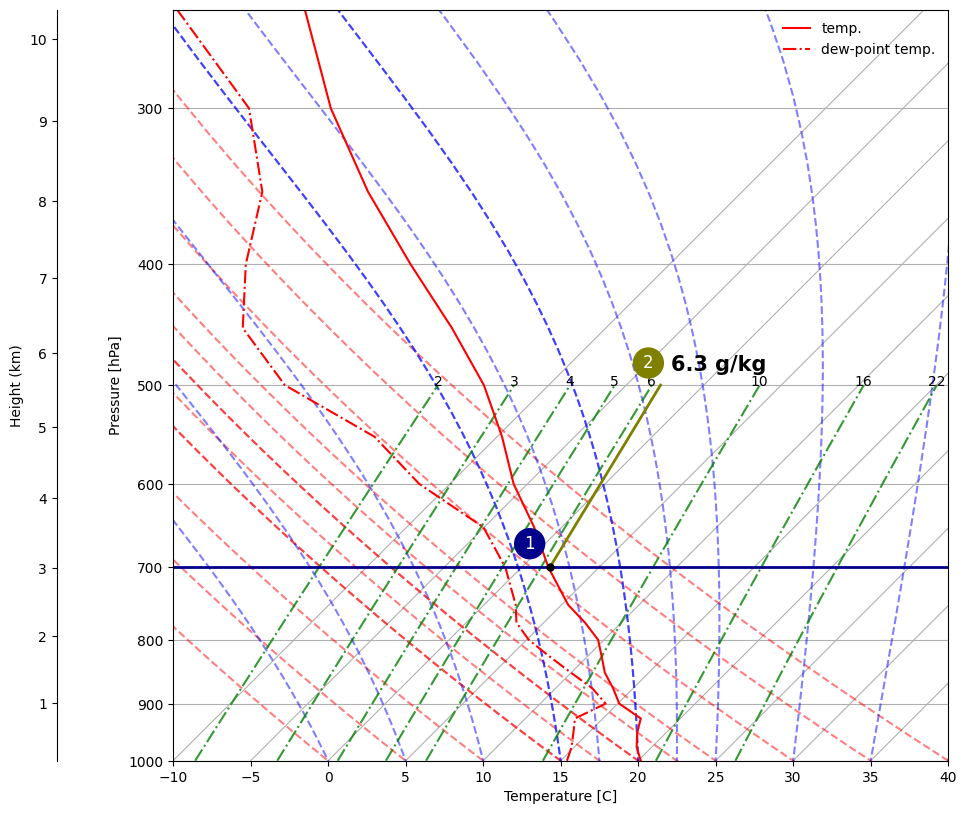

In [10]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Draw the horizontal line at 700 hPa
skew.ax.axhline(y=700, c='darkblue', linestyle='-', linewidth=2)

# Step 1: Find the intersection between the temperature sounding and the 700 hPa isobar
# Get the temperature sounding data
temp_sounding = (ds.t - 273.15).values  # Convert to Celsius
pressure_levels = ds.pressure_level.values  # Pressure levels in hPa

# Ensure pressure levels are sorted in descending order
sorted_indices = np.argsort(pressure_levels)[::-1]
pressure_sorted = pressure_levels[sorted_indices]
temp_sorted = temp_sounding[sorted_indices]

# Find the two surrounding points for 700 hPa
above_idx = np.where(pressure_sorted > 700)[0][-1]  # Last index where pressure > 700
below_idx = np.where(pressure_sorted < 700)[0][0]  # First index where pressure < 700

p1, t1 = pressure_sorted[above_idx], temp_sorted[above_idx]
p2, t2 = pressure_sorted[below_idx], temp_sorted[below_idx]

# Linear interpolation to find the temperature at 700 hPa
intersection_temp = t1 + (t2 - t1) * ((700 - p1) / (p2 - p1))

# Step 2: Calculate the saturation mixing ratio at 700 hPa
e_sat = mpcalc.saturation_vapor_pressure(units.Quantity(intersection_temp, 'degC'))
saturation_mixing_ratio_value = mpcalc.mixing_ratio(e_sat, units.Quantity(700, 'hPa'))

# Step 3: To draw an isohume to 500 hPa, find the dew-point temperature at 500 hPa
# with the same mixing ratio
e_500 = saturation_mixing_ratio_value * 500 * units.hPa / (0.622 + saturation_mixing_ratio_value)
dewpoint_500 = mpcalc.dewpoint(e_500).to('degC').m

# Step 4: Draw the parallel mixing ratio line from 700 hPa to 500 hPa
skew.ax.plot([intersection_temp, dewpoint_500], [700, 500], 
             c='olive', linestyle='-', linewidth=2, label='Saturated Mixing Ratio Line')

# Step 5: Label the mixing ratio at 500 hPa
skew.ax.text(dewpoint_500, 490, f'{saturation_mixing_ratio_value.to("g/kg").magnitude:.1f} g/kg',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Step 6: Mark the intersection point at 700 hPa
skew.ax.plot(intersection_temp, 700, marker='o', markersize=5, color='black')

# Steps labeling 
plt.text(-1, 670, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(-5, 480, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))

### 6. Relative Humidity (RH)

Since relative humidity (RH) is the ratio (expressed as a percentage) of the actual mixing ratio $r_v$ to the saturation mixing ratio $r_s$ (with respect to a plane surface of pure water at the same temperature and pressure),

$$
RH = \frac{r_v}{r_s} \times 100
$$

we can determine it for a single air parcel, at a given pressure, from the previous two calculations. For this sounding, at the 700 hPa level, it is therefore $5.1/6.3\times100=81\%$.

(sec:moist-adiabatic)=
## Moist-adiabatic parcels: Simple clouds

### 1. Lifting Condensation Level (LCL)

The lifting condensation level (LCL) is defined as the level to which an unsaturated (but moist) parcel of air can be lifted adiabatically before it becomes saturated with respect to a plane surface of pure water. We can almost always find such a height, because if you don't change the mixing ratio of a parcel, but keep on cooling it by adiabatic expansion, you will find a pressure level where the parcel's dew-point will equal its actual temperature, and it becomes saturated.

The height of the LCL is often used interchangeably with the cloud base height, although this is only true if the clouds actually consist of parcels which are lifted adiabatically from a certain height. In reality, lifting to the LCL will not always lead to actual clouds, because parcels only rise when they are positively buoyant or otherwise forced upwards, never rise completely adiabatically, but mix with their surroundings, and don't begin condensating exactly where they become supersaturated (we will study all this further in the clouds module). Nevertheless, for positively buoyant parcels, i.e. for "convective clouds" such as shallow cumuli or deep convective thunderstorms, the LCL of the parcel with the dew-point temperature and temperature from near the surface is often a pretty decent first cloud base model.

The LCL of the surface parcel can be found in the diagram below as follows:

1. Draw a mixing ratio line through the surface dew point temperature. This line represents lifting the parcel while keeping its mixing ratio constant.
2. Draw a dry adiabat through the surface temperature. This line represents lifing the parcel and expanding it adiabatically so that its potential tempreature is conserved.
3. The intersection of these lines is the LCL.

The LCL of other parcels in the sounding, lifted from other pressures, can be found by similar constructions.

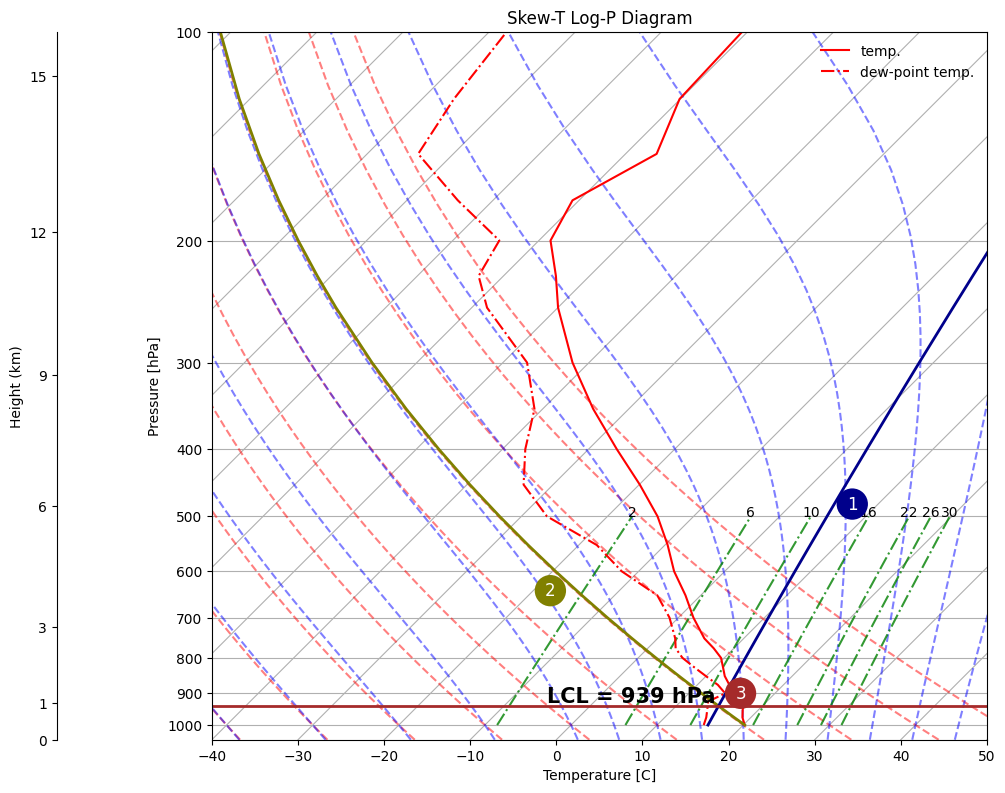

In [337]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Step 1: Get the temperature at 1000 hPa and convert to °C
temp_1000 = ds.t.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

# Define the pressure levels for the dry adiabat (same as your dataset's pressure levels)
pressure_levels = ds.pressure_level.values * units('hPa')

# Calculate the dry adiabat starting from the temperature at 1000 hPa
dry_adiabat = mpcalc.dry_lapse(pressure_levels, 
                               units.Quantity(temp_1000, 'degC'), 
                               units.Quantity(1000, 'hPa'))

# Plot the dry adiabat line
skew.plot(pressure_levels, dry_adiabat, c='olive', linestyle='-', linewidth=2)

# Step 2: Calculate the mixing ratio at 1000 hPa using the dew point temperature
dewpoint_1000 = ds.tdew.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

e = mpcalc.saturation_vapor_pressure(units.Quantity(dewpoint_1000, 'degC'))  # Saturation vapor pressure
mixing_ratio = mpcalc.mixing_ratio(e, units.Quantity(1000, 'hPa'))  # Mixing ratio at 1000 hPa

# Calculate the dew point temperature at each pressure level for the constant mixing ratio line
constant_mixing_ratio_line = []
for p in pressure_levels:
    e = mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), mixing_ratio)  # Vapor pressure at pressure level p
    dewpoint = mpcalc.dewpoint(e)  # Dew point temperature at pressure level p
    constant_mixing_ratio_line.append(dewpoint.m_as('degC'))  # Convert to °C

# Plot the constant mixing ratio line
skew.plot(pressure_levels, constant_mixing_ratio_line, c='darkblue', linestyle='-', linewidth=2)

# Step 3: Find LCL
lcl = mpcalc.lcl(ds.pressure_level[0]*units('hPa'),
                 ds.t[0]*units('K'),
                 ds.tdew[0]*units('K'))
skew.ax.axhline(lcl[0], c='brown', linewidth=2)

# label the pressure
skew.ax.text(-5, 940, f'LCL = 939 hPa',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Steps labeling 
plt.text(7, 480, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-18, 640, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(16, 900, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))

(subsec:equiv-pot)=
### 2. Equivalent potential temperature and condensated water vapour

As we derived in [Thermodynamics (ii)](3.%20Thermodynamics%20(ii).ipynb), the equivalent potential temperature $\theta_e$ (in case of only liquid-vapour phase transformations) is the potential temperature of an air parcel after all water vapour in it has condensated and released its latent heat:

$$
\theta_e = \theta\exp\left(\frac{L_vr_v}{c_{p_m}T}\right)
$$

$\theta_e$ can be considerably larger than $\theta$, because the temperature rise from the latent heat release (i.e. the term $\exp\left(\frac{L_vr_v}{c_{p_m}T}\right)$) can be quite large. To determine $\theta_e$ on a skewT-logP diagram, we must carry out a rather convoluted lifting operation. However, this operation has the additional benefit of showing how to calculate the amount of water vapour that has been condensated; that is to determine the mixing ratio of liquid water, assuming none of the condensate rains out or freezes:

1. Draw a mixing ratio line from the dew-point temperature of interest
2. Draw a dry adiabat from the temperature of interest, and diagnose the LCL at the intersection with line 1.
3. Follow the saturated adiabat from the LCL presssure and temperature, to a pressure where the saturated adiabat and dry adiabat are virtually indistinguishable, e.g. 200 hPa.
4. Follow a dry adiabat down to 1000 hPa, and read off the temperature: $\theta_e = 52.5^{\text{o}}$C.

The trick in step 3 is to lift the parcel along a line of constant $\theta_e$ from its LCL. Along this moist adiabat, the parcel is kept at saturation (i.e. $r_v=r_s$ in the equation above), which is why the line is also sometimes called the "saturated adiabat". If one then lifts the parcel high enough at saturation, the temperature of the parcel is so low that $r_s \rightarrow 0$, i.e. virtually all the water vapour must have condensated into liquid water. In the plot below, we choose 200 hPa. To show this explicitly, we have included another isohume which intersects the parcel at the 200 hPa level -- it has a mixing ratio of only $0.02$ g/kg, i.e. of the original roughly $11$ g/kg water vapour in the parcel (you can read this off the diagram following the procedure outlined in the [mixing ratio section](sec:mixing-ratio)), $11-0.02=10.98$ g/kg has condensated. Therefore, as the equation above shows, at 200 hPa, $\theta_e \approx \theta$, and simply following the dry adiabat back down to 1000 hPa allows us to read off this value for $\theta$.


To calculate the condensated water vapour of a parcel above the LCL, one can always follow the approach we took in passing above: If you intersect an isohume with a saturated adiabat at the level of interest, this will tell you the $r_v$ in the parcel at that level, because along a saturated adiabat the parcel is kept at saturation, and so at any pressure $p$ above the LCL, $r_{v,p}=r_{s,p}$. Before the parcel reached the LCL, its $r_v$ is that of the isohume that you lifted it along to reach the LCL ($r_{v,0}$), i.e. the condensated water vapour must be equal to $r_{s,p} - r_{v,0}$.


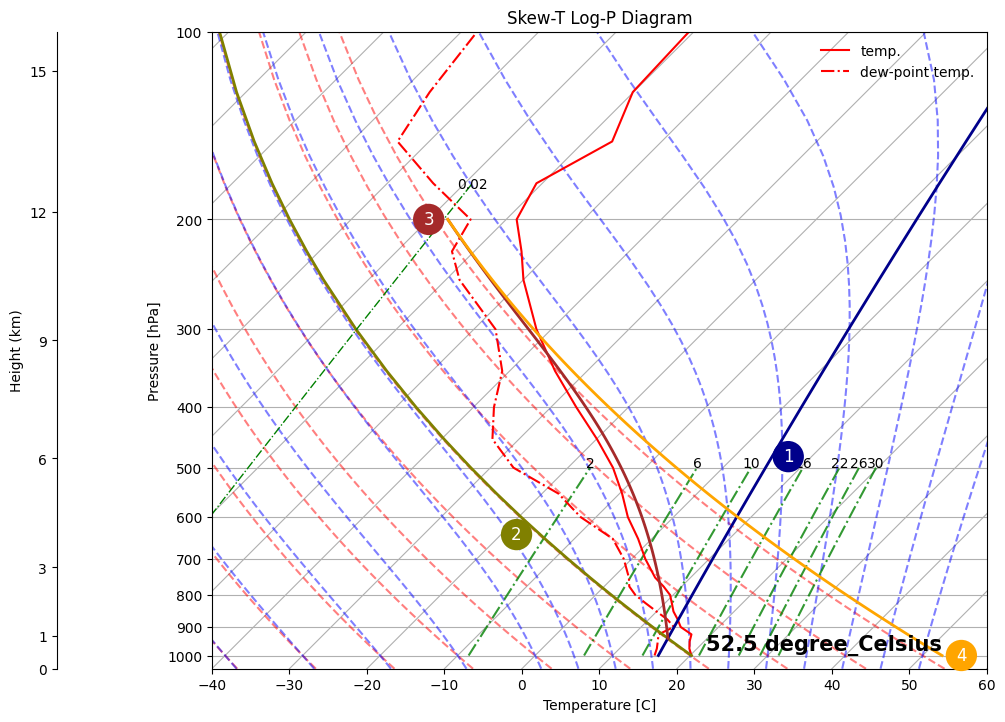

In [60]:
# Make the plot
skew = plot_basic_skewt()
skew.ax.set_xlim(-40,60)

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Step 1: Get the temperature at 1000 hPa and convert to °C
temp_1000 = ds.t.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

# Define the pressure levels for the dry adiabat (same as your dataset's pressure levels)
pressure_levels = ds.pressure_level.values * units('hPa')

# Calculate the dry adiabat starting from the temperature at 1000 hPa
dry_adiabat = mpcalc.dry_lapse(pressure_levels, 
                               units.Quantity(temp_1000, 'degC'), 
                               units.Quantity(1000, 'hPa'))

# Plot the dry adiabat line
skew.plot(pressure_levels, dry_adiabat, c='olive', linestyle='-', linewidth=2)

# Step 2: Calculate the mixing ratio at 1000 hPa using the dew point temperature
dewpoint_1000 = ds.tdew.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

e = mpcalc.saturation_vapor_pressure(units.Quantity(dewpoint_1000, 'degC'))  # Saturation vapor pressure
mixing_ratio = mpcalc.mixing_ratio(e, units.Quantity(1000, 'hPa'))  # Mixing ratio at 1000 hPa

# Calculate the dew point temperature at each pressure level for the constant mixing ratio line
constant_mixing_ratio_line = []
for p in pressure_levels:
    e = mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), mixing_ratio)  # Vapor pressure at pressure level p
    dewpoint = mpcalc.dewpoint(e)  # Dew point temperature at pressure level p
    constant_mixing_ratio_line.append(dewpoint.m_as('degC'))  # Convert to °C

# Plot the constant mixing ratio line
skew.plot(pressure_levels, constant_mixing_ratio_line, c='darkblue', linestyle='-', linewidth=2)

# Step 3: Calculate wet-bulb temperature at the surface (1000 hPa)
wet_bulb = mpcalc.wet_bulb_temperature(
    ds.pressure_level[0] * units('hPa'),  # Surface pressure
    ds.t[0] * units('K'),                 # Surface temperature
    ds.tdew[0] * units('K')               # Surface dewpoint temperature
)

# Step 4: Calculate the LCL (Lifted Condensation Level)
lcl_pressure, lcl_temperature = mpcalc.lcl(
    ds.pressure_level[0] * units('hPa'),  # Surface pressure
    ds.t[0] * units('K'),                 # Surface temperature
    ds.tdew[0] * units('K')               # Surface dewpoint temperature
)

#  Step 5 :Calculate the moist adiabat from the LCL to 200 hPa
moist_adiabat = mpcalc.moist_lapse(
    units.Quantity(np.linspace(lcl_pressure.m, 200, 100), 'hPa'),
    lcl_temperature
)

# Plot the moist adiabat from the LCL to 200 hPa
skew.plot(
    np.linspace(lcl_pressure.m, 200, 100),
    moist_adiabat.to('degC').magnitude,
    c='brown', linestyle='-', linewidth=2
)

#  Step 6: Calculate the dry adiabat from 200 hPa to the surface
potential_temperature = mpcalc.potential_temperature(units.Quantity(200, 'hPa'), moist_adiabat[-1])
dry_adiabat = mpcalc.dry_lapse(
    units.Quantity(np.linspace(ds.pressure_level[0].item(), 200, 100), 'hPa'),
    potential_temperature,
    units.Quantity(1000, 'hPa')
)

# Plot the dry adiabat from 200 hPa to the surface
skew.plot(
    np.linspace(ds.pressure_level[0].item(), 200, 100),
    dry_adiabat.to('degC').magnitude,
    c='orange', linestyle='-', linewidth=2
)

# Print the this potential temperature
# potential_temperature_celsius = potential_temperature.metpy.convert_units('degC').item()
skew.ax.text(22, 1000, f"{potential_temperature.to('degC'):.1f}",
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')


# Add a mixing ratio line to illustrate how dry the parcel is at 200 hPa
constant_mixing_ratio_line = []
for p in pressure_levels:
    constant_mixing_ratio_line.append(mpcalc.dewpoint(mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), 2e-5)).m_as('degC'))  # Convert to °C
skew.plot(pressure_levels[:24], constant_mixing_ratio_line[:24], c='green', linestyle='-.', linewidth=1)
skew.ax.text(-70, 180, '0.02', color='black', fontsize=10, verticalalignment='bottom')

# Steps labeling 
plt.text(7, 480, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-18, 640, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-70, 200, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(55, 1000, '4', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='orange', edgecolor='none', boxstyle='circle', pad=0.4))

### 3. Wet Bulb Temperature

For an unsaturated parcel with a given $r_v$, $T$ and $p$, the wet-bulb temperature $T_w$ can be reached by continuously supplying it with liquid water. Since the parcel is unsaturated, the liquid water will evaporate. In an adiabatic setting, the latent heat required to achieve this evaporation must come from the parcel itself, so it will cool down. Eventually, this cooling will saturate the parcel; at this point, it has the wet-bulb temperature. Hence, $T_w$ can be interpreted as something like the capacity of an air parcel to cool by evaporating liquid water in it. This is super relevant to human thermal comfort, since we cool ourselves this way, and to rain, which when falling into unsaturated air under cloud base will tend to evaporatively cool the air towards $T_w$.

For an air parcel from the sounding at 1000 hPa, $T_w$ can be measured on a SkewT-logP diagram as follows:

1. Draw a mixing ratio line through the 1000 hPa dew point.
2. Draw a dry adiabat through the 1000 hPa temperature.
3. The intersection of these lines is the LCL. Draw a moist adiabat through the LCL back down to 1000 hPa.

Here, that gives us a wet-bulb temperature of 17.35°C. There also exists a wet-bulb *potential* temperature $\theta_w$, for which one in step 3 traces the parcel down all the way to the reference pressure of 1000 hPa. In this example, the wet-bulb potential temperature is the same as the wet-bulb temperature, since the pressure level of interest *is* at 1000hPa.

Why do we have to do this lifting to the LCL and moving back down to find $T_w$? The LCL does not appear in the definition of $T_w$ at all? This comes from our requirement that the parcel stays adiabatic. In such a setting, expanding an unsaturated parcel to a lower pressure is the only way to make it reach saturation (which happens at the LCL). To then adiabatically keep the parcel *at* saturation, we move it down a moist adiabat (remember, it is also sometimes called a saturated adiabat). But because the parcel itself is not saturated when moving down from the LCL, to keep it on the saturated adiabat, we must add liquid water to the parcel, evaporate it and thus cool it.

In fact, once you have found $T_w$, you can read off the amount of liquid water that must be added to a parcel to cool it there, by reading off the mixing ratio of the initial parcel (see [the mixing ratio section](sec:mixing-ratio)), and the mixing ratio at $T_w$: The difference is what must have been supplied as liquid water to bring the parcel to saturation at $T_w$.

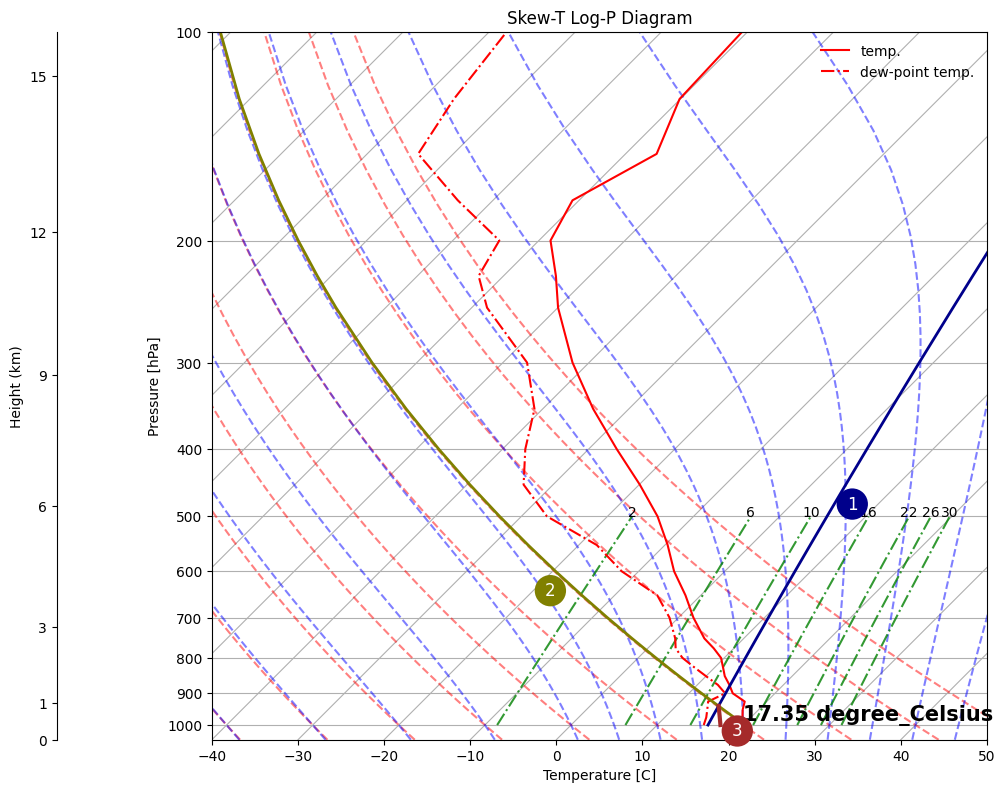

In [19]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Step 1: Get the temperature at 1000 hPa and convert to °C
temp_1000 = ds.t.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

# Define the pressure levels for the dry adiabat (same as your dataset's pressure levels)
pressure_levels = ds.pressure_level.values * units('hPa')

# Calculate the dry adiabat starting from the temperature at 1000 hPa
dry_adiabat = mpcalc.dry_lapse(pressure_levels, 
                               units.Quantity(temp_1000, 'degC'), 
                               units.Quantity(1000, 'hPa'))

# Plot the dry adiabat line
skew.plot(pressure_levels, dry_adiabat, c='olive', linestyle='-', linewidth=2)

# Step 2: Calculate the mixing ratio at 1000 hPa using the dew point temperature
dewpoint_1000 = ds.tdew.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

e = mpcalc.saturation_vapor_pressure(units.Quantity(dewpoint_1000, 'degC'))  # Saturation vapor pressure
mixing_ratio = mpcalc.mixing_ratio(e, units.Quantity(1000, 'hPa'))  # Mixing ratio at 1000 hPa

# Calculate the dew point temperature at each pressure level for the constant mixing ratio line
constant_mixing_ratio_line = []
for p in pressure_levels:
    e = mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), mixing_ratio)  # Vapor pressure at pressure level p
    dewpoint = mpcalc.dewpoint(e)  # Dew point temperature at pressure level p
    constant_mixing_ratio_line.append(dewpoint.m_as('degC'))  # Convert to °C

# Plot the constant mixing ratio line
skew.plot(pressure_levels, constant_mixing_ratio_line, c='darkblue', linestyle='-', linewidth=2)

# Step 3: Calculate wet-bulb temperature at the surface (1000 hPa)
wet_bulb = mpcalc.wet_bulb_temperature(
    ds.pressure_level[0] * units('hPa'),  # Surface pressure
    ds.t[0] * units('K'),                 # Surface temperature
    ds.tdew[0] * units('K')               # Surface dewpoint temperature
)

# Print the wet-bulb temperature
wet_bulb_celsius = wet_bulb.metpy.convert_units('degC').item()
skew.ax.text(20, 1000, f"{wet_bulb_celsius:.2f}",
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Step 4: Calculate the LCL (Lifted Condensation Level)
lcl_pressure, lcl_temperature = mpcalc.lcl(
    ds.pressure_level[0] * units('hPa'),  # Surface pressure
    ds.t[0] * units('K'),                 # Surface temperature
    ds.tdew[0] * units('K')               # Surface dewpoint temperature
)

# Calculate the moist adiabat from the LCL to the surface
moist_adiabat = mpcalc.moist_lapse(
    units.Quantity(np.linspace(lcl_pressure.m, ds.pressure_level[0].item(), 100), 'hPa'),
    lcl_temperature
)

# Plot the moist adiabat from the LCL to the surface
skew.plot(
    np.linspace(lcl_pressure.m, ds.pressure_level[0].item(), 100),
    moist_adiabat.to('degC').magnitude,
    c='brown', linestyle='-', linewidth=3
)

# Steps labeling 
plt.text(7, 480, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-18, 640, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(20, 1020, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))

(sec:stability)=
## Stability and convection


### 1. Diagnosing stability of layers
Generally speaking, we expect convection (dry or moist) to occur when parcels become positively buoyant with respect to their environment. In the skewT-logP diagrams we analyse in this course, we diagnose positive buoyancy when the actual temperature of a parcel is warmer than that of the atmosphere. We should keep in mind that when the air is moist, we should really use the virtual temperature, but this introduces some complications in reading the diagrams, so we'll ignore it here. So to judge the "stability" of air layers, we ask ourselves: If we adiabatically lift a parcel from the atmospheric sounding upwards a tiny bit, will it still be warmer than the environment? To judge if this is the case, we must identify the parcel's lapse rate if we lift it dry adiabatically ($\Gamma_d$) or moist adiabatically ($\Gamma_m$), and compare these lapse rates to that of the sounding ($\Gamma$). As discussed in [Thermodyanmics (ii)](3.%20Thermodynamics%20(ii).ipynb), because $\Gamma = -dT/dz$, a *larger* value of $\Gamma$ indicates a more *rapid* dropoff of temperature with height, so a sounding with a larger *Gamma* is more unstable. Additionally, since dry adiabatic lifting cools the parcel down more than moist adiabatic lifting (where there is latent heat release warming the parcel), the temperature drops off with height more rapidly along a dry adiabat than a moist adiabat, i.e. $\Gamma_d \geq \Gamma_m$.

So there can be three scenarios for the parcel:

1. Absolutely Stable: When lifting a parcel moist adiabatically and dry adiabatically, they always remain colder than their environment and are negatively buoyant. Put differently, the temperature dropoff with height of the parcel ($\Gamma_d$, $\Gamma_m$) is always larger than that of the environment $\Gamma$:

$$
\Gamma_d > \Gamma
$$
$$
\Gamma_m > \Gamma
$$

2. Absolutely Unstable: When lifting a parcel moist adiabatically and dry adiabatically, they are always warmer than their environment and thus positively buoyant. Put differently, the temperature dropoff with height of the parcel ($\Gamma_d$, $\Gamma_m$) is always smaller than that of the environment $\Gamma$:

$$
\Gamma_d < \Gamma
$$
$$
\Gamma_m < \Gamma
$$

3. Conditionally Unstable: When lifting a parcel dry adiabatically, it is colder than the environment and thus negatively buoyant, i.e. the temperature dropoff with height of the parcel ($\Gamma_d$) is larger than that of the environment $\Gamma$. However, when lifting a parcel moist adiabatically, it is *warmer* than the environment and thus positively buoyant, i.e. the temperature dropoff with height of the parcel ($\Gamma_m$) is *smaller* than that of the environment $\Gamma$ (i.e. the parcel is unstable, on the *condition* that it is saturated):

$$
\Gamma_d < \Gamma
$$
$$
\Gamma_m > \Gamma
$$  

On a skewT-logP diagram, we can use these conditions to find out which layers in a sounding are stable, unstable or conditionally stable:

1. In the blue region, lifting a parcel along either a dry or a moist adiabat from any point in this layer would make it colder than the sounding temperature, i.e. the layer is stable
2. In the red region, lifting a parcel along either a dry or a moist adiabat from any point in this layer would make it warmer than the sounding temperature, i.e. the layer is unstable
3. In the yellow region, lifting a parcel along the dry adiabat would make it colder than the environment, but lifting it along a moist adiabat would make it warmer, i.e. the layer is conditionally unstable

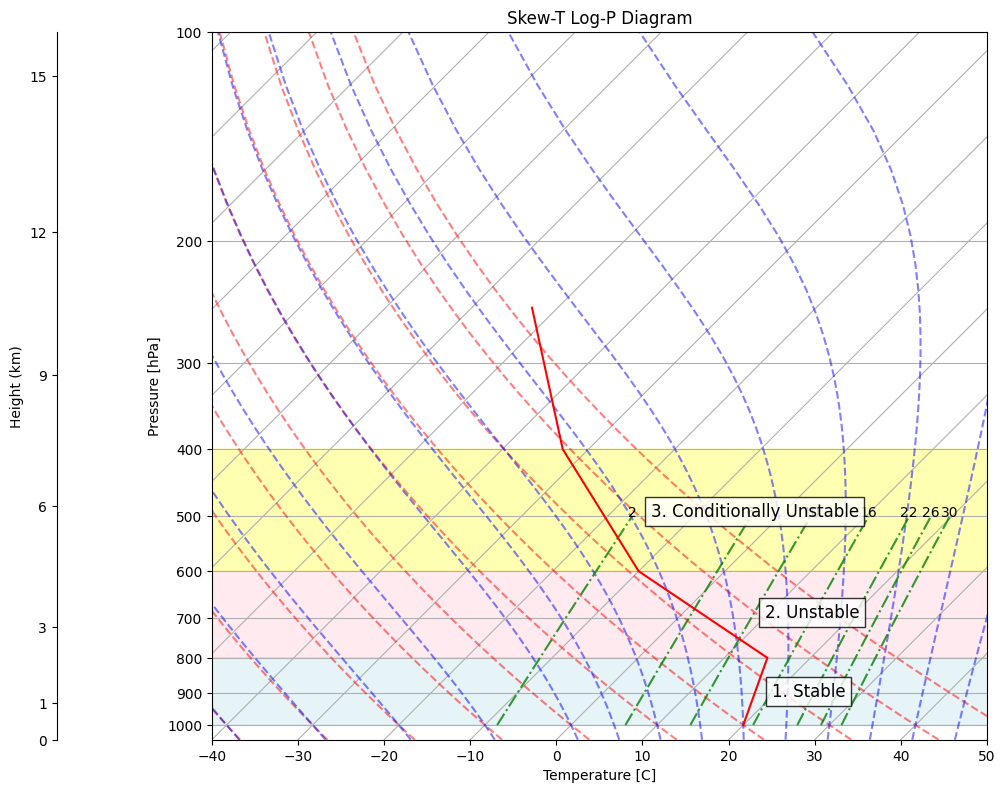

In [103]:
# Make the plot
skew = plot_basic_skewt()

# Given points (temperature in degrees Celsius, pressure in hPa)
points = [(20, 1000), (15, 800), (-10, 600), (-33, 400), (-53, 250)]

# Extract temperature and pressure values
temperatures = np.array([point[0] for point in points])
pressures = np.array([point[1] for point in points])

# Highlight the regions
skew.ax.fill_betweenx(ds.pressure_level, -80, 50, where=(ds.pressure_level <= 600) & (ds.pressure_level >= 400), color='yellow', alpha=0.3)
skew.ax.fill_betweenx(ds.pressure_level, -80, 50, where=(ds.pressure_level <= 800) & (ds.pressure_level >= 600), color='pink', alpha=0.3)
skew.ax.fill_betweenx(ds.pressure_level, -80, 50, where=(ds.pressure_level <= 1000) & (ds.pressure_level >= 800), color='lightblue', alpha=0.3)

# Add a label to indicate instability in the highlighted region
skew.ax.text(20, 910, '1. Stable', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
skew.ax.text(10, 700, '2. Unstable', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))
skew.ax.text(-15, 500, '3. Conditionally Unstable', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

# Plot the sounding
_=skew.plot(pressures, temperatures, c='red', label='temp.')

Unstable layers can be formed by:
- Heating a layer from below: For instance, the surface layer of the daytime boundary layer is often unstable, since it is warmed from below, and this drives both the dry convective overturning in the boundary layer, and keeps the temperature profile of that layer close to the dry adiabat. You can often recognise the sounding of a daytime boundary layer by looking for these features.
- Cooling a air layer from above: For instance, the ocean surface temperature is often rather constant throughout a daily cycle, since the ocean's heat capacity is very large. However, at night, the overlying atmosphere cools, since it emits longwave radiation to space, but does not absorb shortwave radiation from the sun. This means that the surface layer will become increasingly unstable. Indeed, more convection is usually triggered over the ocean towards the end of the night.
- Saturating a conditionally unstable layer. This could happen if one  mechanically forces moist or cold air parcels upwards into such a layer. Alternatively, it occurs when air parcels rising through an unstable layer (e.g. near the surface) develop some vertical momentum. If that momentum is large enough to carry them to their LCL in the conditionally unstable layer above, they become unstable and develop vertically. Cumulus clouds often form this way.

Many severe weather prediction practitioners rely on analyzing skewT-logP diagrams, because they can quickly give you a feeling for the potential of moist convective parcels to destabilise and rise to the tropopause, i.e. to form thunderstorms. Such "convective clouds" can be characterised in several ways, and we will cover them next.

### 2. Level of Free Convection (LFC) & Equilibrium Level (EL)

First, the "level of free convection" (LFC) is the level where a parcel lifted along a moist adiabat, attains a temperature which exceeds the environmental temperature, and becomes positively buoyant (or free to convect, if you will). This level must thus lie above the LCL. The equilibrium Level (EL) is then the next level at which the positively buoyant parcel becomes negatively buoyant again, i.e. it is the simplest possible model for the top of convective clouds.

To find it on a Skew-T Log-P Diagram, for the 1000 hPa parcel:

1. Draw a mixing ratio line through the surface dew point.
2. Draw a dry adiabat through the surface temperature.
3. The intersection of these lines is the LCL.
4. Draw a moist adiabat through the LCL.

Now:
- The LFC is the first intersection of the moist adiabat and the temperature sounding.
- The EL is the first intersection of the moist adiabat and the temperature sounding above the LFC.

The LFC and EL do not always exist: When moving along a moist adiabat from the LCL, there is no guarantee that a parcel will ever be warmer than the environment, and thus that convective clouds are likely to form from the lifted parcel.

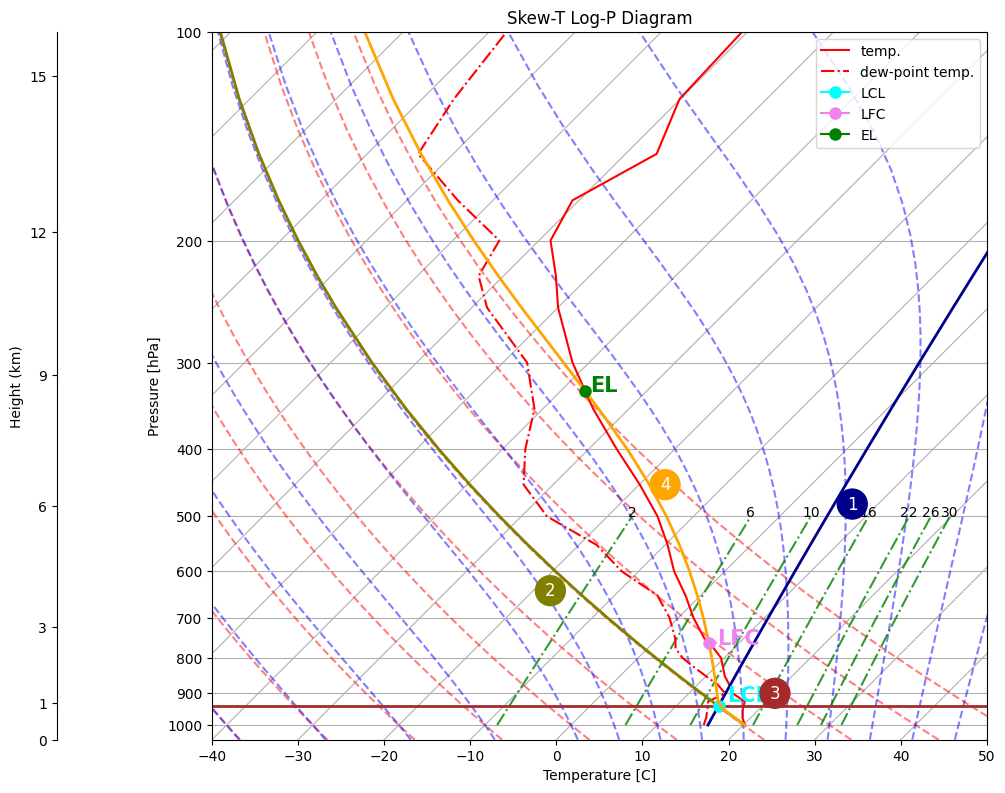

In [61]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Step 1: Get the temperature at 1000 hPa and convert to °C
temp_1000 = ds.t.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

# Define the pressure levels for the dry adiabat (same as your dataset's pressure levels)
pressure_levels = ds.pressure_level.values * units('hPa')

# Calculate the dry adiabat starting from the temperature at 1000 hPa
dry_adiabat = mpcalc.dry_lapse(pressure_levels, 
                               units.Quantity(temp_1000, 'degC'), 
                               units.Quantity(1000, 'hPa'))

# Plot the dry adiabat line
skew.plot(pressure_levels, dry_adiabat, c='olive', linestyle='-', linewidth=2)

# Step 2: Calculate the mixing ratio at 1000 hPa using the dew point temperature
dewpoint_1000 = ds.tdew.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

e = mpcalc.saturation_vapor_pressure(units.Quantity(dewpoint_1000, 'degC'))  # Saturation vapor pressure
mixing_ratio = mpcalc.mixing_ratio(e, units.Quantity(1000, 'hPa'))  # Mixing ratio at 1000 hPa

# Calculate the dew point temperature at each pressure level for the constant mixing ratio line
constant_mixing_ratio_line = []
for p in pressure_levels:
    e = mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), mixing_ratio)  # Vapor pressure at pressure level p
    dewpoint = mpcalc.dewpoint(e)  # Dew point temperature at pressure level p
    constant_mixing_ratio_line.append(dewpoint.m_as('degC'))  # Convert to °C

# Plot the constant mixing ratio line
skew.plot(pressure_levels, constant_mixing_ratio_line, c='darkblue', linestyle='-', linewidth=2)

# Step 3: Find LCL
lcl = mpcalc.lcl(ds.pressure_level[0]*units('hPa'),
                 ds.t[0]*units('K'),
                 ds.tdew[0]*units('K'))
skew.ax.axhline(lcl[0], c='brown', linewidth=2)

prof = mpcalc.parcel_profile(ds.pressure_level*units('hPa'),
                             ds.t[0]*units('K'),
                             ds.tdew[0]*units('K'))
skew.ax.plot(lcl[1].m_as('degC'), lcl[0].m_as('hPa'), 
            marker='o', markersize=8, color='cyan', label='LCL')
skew.ax.text(lcl[1].m_as('degC') + 1, lcl[0].m_as('hPa'), f'LCL',
             color='cyan', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Plot parcel
skew.plot(ds.pressure_level, prof.values-273.15, c='orange', linewidth=2)


# Step 4: Calculate LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(
    ds.pressure_level.values * units('hPa'),
    ds.t.values * units('K'),
    ds.tdew.values * units('K')
)

# Plot LFC point
skew.ax.plot(lfc_temperature.m_as('degC'), lfc_pressure.m_as('hPa'), 
            marker='o', markersize=8, color='violet', label='LFC')
skew.ax.text(8, 775, f'LFC',
             color='violet', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Step 5: Calculate EL
el_pressure, el_temperature = mpcalc.el(
    ds.pressure_level.values * units('hPa'),
    ds.t.values * units('K'),
    ds.tdew.values * units('K')
)

# Plot EL point
skew.ax.plot(el_temperature.m_as('degC'), el_pressure.m_as('hPa'), 
            marker='o', markersize=8, color='green', label='EL')
skew.ax.text(-36, 335, f'EL',
             color='green', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Add legend
skew.ax.legend()

# Steps labeling 
plt.text(7, 480, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-18, 640, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(20, 900, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(-17, 450, '4', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='orange', edgecolor='none', boxstyle='circle', pad=0.4))

### 3. Convective Inhibition (CIN) and Convective Available Potential Energy (CAPE)

When a layer is stable, this does not mean that parcels can't rise through it at all. For example, parcels may be forced upward by an object (a mountain) or by other amtospheric dynamics. Is is thus often reasonable to ask: How much vertical kinetic energy do we need to give a parcel that is negatively buoyant over a layer, for it to still reach the layer top? For parcels that move adiabatically, the answer to this question is called the "Convective Inhibition" (CIN): The potential energy needed to overcome the negative buoyancy work done by the environment on the parcel. CIN is therefore defined by vertically integrating the buoyancy over the negatively buoyant layer, e.g. between $z_{\text{bot}}$ and $z_{\text{top}}$:

$$
\text{CIN} = \int_{z_{\text{bot}}}^{z_{\text{top}}} g\left(\frac{T_{\text{parcel}} - T_{\text{env}}}{T_{\text{env}}}\right)dz
$$

So, on a skewT-logP diagram, the CIN is proportional to the area between the lifted parcel (along dry or moist adiabats), over the layer where $T_{\text{parcel}}$ lies to the left of $T_{\text{env}}$. In the sounding we've been analysing, the surface parcel is indeed immediately negatively buoyant, up to its LFC. So, to indicate the CIN for this layer in the skewT-logP diagram, we first lift the parcel adiabatically from the surface as in the preceding example (steps 1-3), and then we shade the area between the surface and the LFC. CIN is thus a negative number. 

Multiple layers in the sounding might have CIN. For instance, it would be fair to characterise the upper part of the sounding (above the tropopause) as an area of very large CIN. This is often not done, because the CIN is so large that convective weather hardly ever happens in the stratosphere, and we thus rather ignore it.

Conversely, one might ask: *If* a parcel reaches its LFC, how much positively buoyant energy is there that potentially could be converted into vertical kinetic energy, before it reaches the EL? The answer to this question is called the Convective Available Potential Energy (CAPE). It is the complement of CIN, if $z_{\text{bot}}$ is the LFC and $z_{\text{top}}$ is the EL:

$$
\text{CAPE} = \int_{z_{\text{LFC}}}^{z_{\text{EL}}} g\left(\frac{T_{\text{parcel}} - T_{\text{env}}}{T_{\text{env}}}\right)dz
$$

On a skewT-logP chart, CAPE is thus proportional to the area between the moist adiabat and the temperature sounding between the LFC and the EL. It is a *positive* number. If convective parcels at the LFC have zero vertical motion, CAPE also tells us the maximum rise speed the parcel can attain, if all this buoyant potential energy were converted into kinetic energy:

$$
\frac{1}{2}w_{max}^2 = \text{CAPE}
$$

Because of its simplicitly, CAPE is perhaps the most commonly used indicator for the potential of thunderstorm development. In this sounding for example, which is from a few hours before a devastating rainfall event over Valencia on 29 October 2024, there is quite some CAPE. But would the surface warm just a little, there would be an enormous amount of CAPE. We will investigate such sensitivites next.

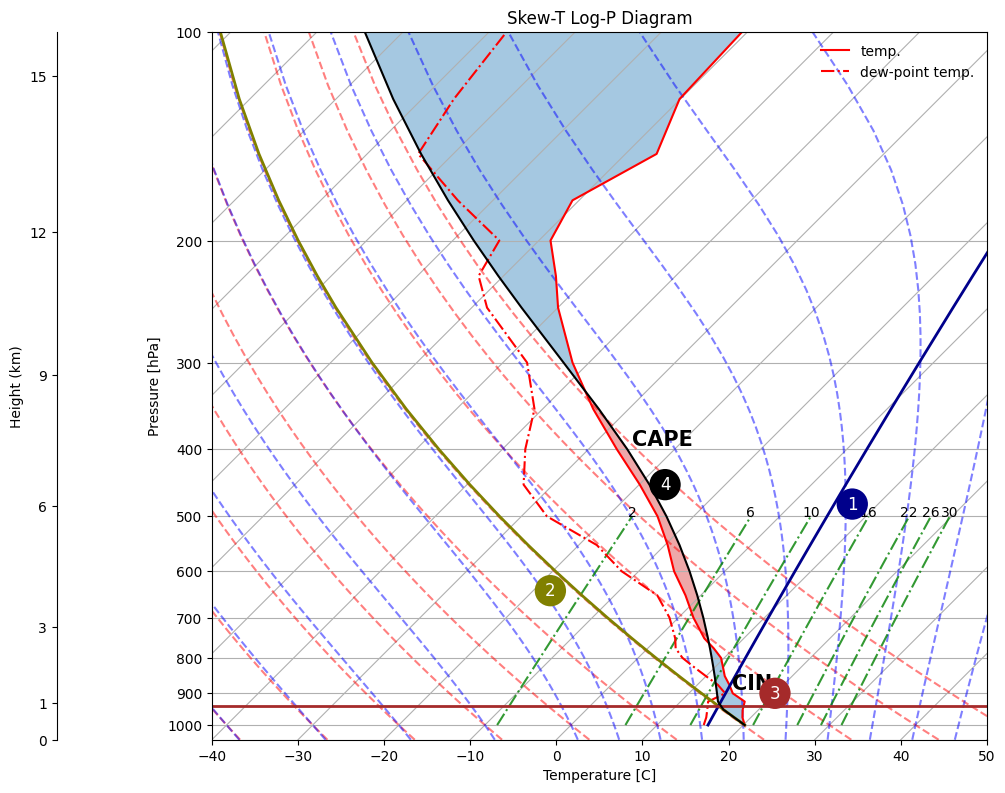

In [106]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Step 1: Get the temperature at 1000 hPa and convert to °C
temp_1000 = ds.t.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

# Define the pressure levels for the dry adiabat (same as your dataset's pressure levels)
pressure_levels = ds.pressure_level.values * units('hPa')

# Calculate the dry adiabat starting from the temperature at 1000 hPa
dry_adiabat = mpcalc.dry_lapse(pressure_levels, 
                               units.Quantity(temp_1000, 'degC'), 
                               units.Quantity(1000, 'hPa'))

# Plot the dry adiabat line
skew.plot(pressure_levels, dry_adiabat, c='olive', linestyle='-', linewidth=2)

# Step 2: Calculate the mixing ratio at 1000 hPa using the dew point temperature
dewpoint_1000 = ds.tdew.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

e = mpcalc.saturation_vapor_pressure(units.Quantity(dewpoint_1000, 'degC'))  # Saturation vapor pressure
mixing_ratio = mpcalc.mixing_ratio(e, units.Quantity(1000, 'hPa'))  # Mixing ratio at 1000 hPa

# Calculate the dew point temperature at each pressure level for the constant mixing ratio line
constant_mixing_ratio_line = []
for p in pressure_levels:
    e = mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), mixing_ratio)  # Vapor pressure at pressure level p
    dewpoint = mpcalc.dewpoint(e)  # Dew point temperature at pressure level p
    constant_mixing_ratio_line.append(dewpoint.m_as('degC'))  # Convert to °C

# Plot the constant mixing ratio line
skew.plot(pressure_levels, constant_mixing_ratio_line, c='darkblue', linestyle='-', linewidth=2)

# Step 3: Find LCL
lcl = mpcalc.lcl(ds.pressure_level[0]*units('hPa'),
                 ds.t[0]*units('K'),
                 ds.tdew[0]*units('K'))
skew.ax.axhline(lcl[0], c='brown', linewidth=2)

prof = mpcalc.parcel_profile(ds.pressure_level*units('hPa'),
                             ds.t[0]*units('K'),
                             ds.tdew[0]*units('K'))
# Plot parcel for CAPE & CIN
skew.plot(ds.pressure_level, prof.values-273.15, c='k')
skew.shade_cape(ds.pressure_level.values*units('hPa'),
                (ds.t.values-273.15)*units('degC'),
                (prof.values-273.15)*units('degC'))

skew.shade_cin(ds.pressure_level.values*units('hPa'),
                (ds.t.values-273.15)*units('degC'),
                (prof.values-273.15)*units('degC'))

# Label the CAPE and CIN
skew.ax.text(-25, 400, f'CAPE',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

skew.ax.text(15, 900, f'CIN',
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Steps labeling 
plt.text(7, 480, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-18, 640, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='olive', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(20, 900, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(-17, 450, '4', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='black', edgecolor='none', boxstyle='circle', pad=0.4))

### 4. Convective condensation level

Many problems of forecasting convective clouds involve posing "what if" scenarios. So, instead of lifting the surface parcel, one could ask "how much does this surface parcel have to warm, for convective clouds to spontaneously form"? Over land, we might ask such a question given a morning sounding, expecting the near-surface layer to warm in the coming hours. Therefore, when assessing the risk for thunderstorms, it is often useful to test how much warmer one would have to make the surface parcel, to make it spontaneously reach an LFC. This temperature is called the "convective temperature" $T_c$ -- i.e. it is the surface temperature at which adiabatic parcels are positively buoyant all the way up to the LFC (and therefore all the way to the EL), while keeping the surface dew-point fixed.(often, the surface dew-point also does not change so much during the first hours of a day). The corresponding pressure level at which the convective cloud base is then predicted is called the "convective condensation level" (CCL). To find $T_c$ and the CCL:

1. Draw a mixing ratio line through the surface dew point. If you want the dew-point to be more representative of the lower atmosphere, rather than just the surface, you can draw it at an average of the dew-point over the lower 100 hPa.
2. Find the combination of a dry and moist adiabat that intersect the mixing ratio line such that the parcel temperature is always warmer than the temperature sounding. This may take some trial and error. At the level of the intersection, you can read off the CCL; the lifted parcel's surface temperature is $T_c$.

Here, $T_c=25^{\text{o}}C$, an entirely reacheable value if the sounding's surface temperature ($20^{\text{o}}C$) is measured in the morning.

Text(20, 900, '3')

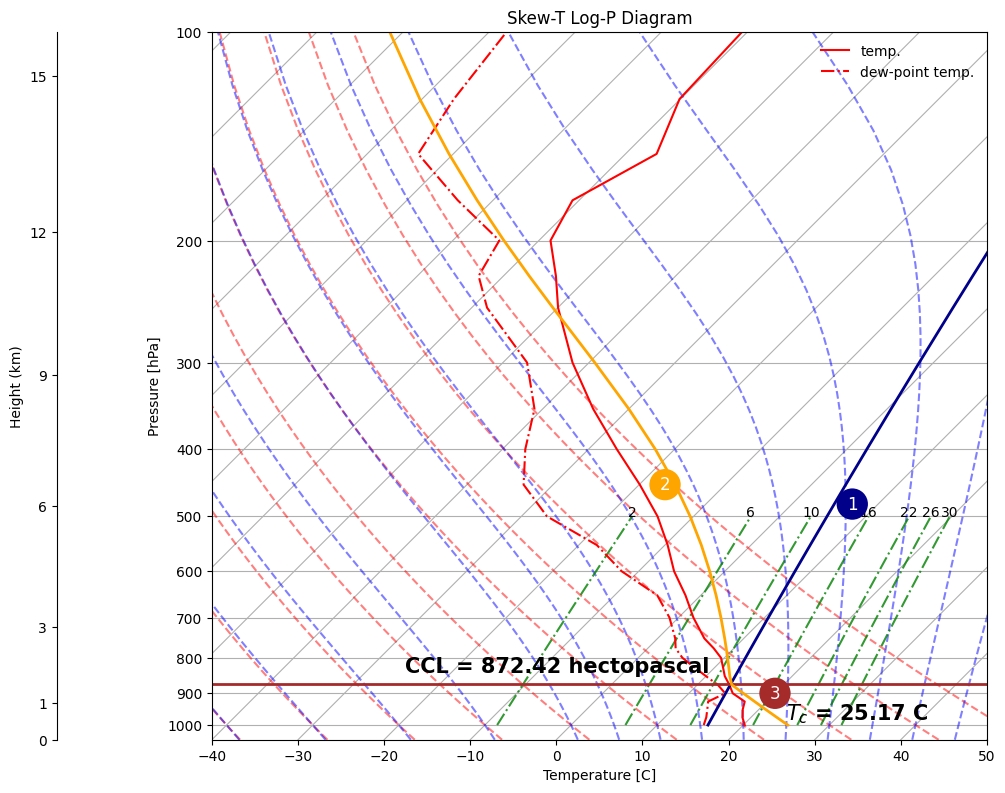

In [196]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

# Step 1: Get the temperature at 1000 hPa and convert to °C
temp_1000 = ds.t.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

# Define the pressure levels for the dry adiabat (same as your dataset's pressure levels)
pressure_levels = ds.pressure_level.values * units('hPa')

# Calculate the dry adiabat starting from the temperature at 1000 hPa
dry_adiabat = mpcalc.dry_lapse(pressure_levels, 
                               units.Quantity(temp_1000, 'degC'), 
                               units.Quantity(1000, 'hPa'))

# Calculate the mixing ratio at 1000 hPa using the dew point temperature
dewpoint_1000 = ds.tdew.sel(pressure_level=1000).values - 273.15  # Convert from K to °C

e = mpcalc.saturation_vapor_pressure(units.Quantity(dewpoint_1000, 'degC'))  # Saturation vapor pressure
mixing_ratio = mpcalc.mixing_ratio(e, units.Quantity(1000, 'hPa'))  # Mixing ratio at 1000 hPa

# Calculate the dew point temperature at each pressure level for the constant mixing ratio line
constant_mixing_ratio_line = []
for p in pressure_levels:
    e = mpcalc.vapor_pressure(units.Quantity(p, 'hPa'), mixing_ratio)  # Vapor pressure at pressure level p
    dewpoint = mpcalc.dewpoint(e)  # Dew point temperature at pressure level p
    constant_mixing_ratio_line.append(dewpoint.m_as('degC'))  # Convert to °C

# Plot the constant mixing ratio line
skew.plot(pressure_levels, constant_mixing_ratio_line, c='darkblue', linestyle='-', linewidth=2)

# Step 3: Find CCL
lcl = mpcalc.lcl(ds.pressure_level[0]*units('hPa'),
                 (ds.t[0]+5)*units('K'),
                 ds.tdew[0]*units('K'))
skew.ax.axhline(lcl[0], c='brown', linewidth=2)

skew.ax.text(-25, 850, f"CCL = {lcl[0]:.2f}",
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

prof = mpcalc.parcel_profile(ds.pressure_level*units('hPa'),
                             (ds.t[0]+5)*units('K'),
                             ds.tdew[0]*units('K'))

# Plot parcel
skew.plot(ds.pressure_level, prof.values-273.15, c='orange', linewidth=2)

skew.ax.text(25, 1000, f"$T_c$ = {prof.values[0]-273.15:.2f} C",
             color='black', fontsize=15, verticalalignment='bottom', fontweight='bold')

# Steps labeling 
plt.text(7, 480, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-17, 450, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='orange', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(20, 900, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))

(sec:ascent-descent)=
## Lifting followed by latent heat release and descent

Many meteorological analyses consist of subsequently carrying out several operations, and analysing the result. A famous example is lifting an air mass over a mountain.

Let us assume that the parcel at 600 hPa encounters a mountain, and is forced to ascend adiabatically to 400 hPa. It will then follow trajectory 1 in the skewT-logP plot below, i.e. the parcel becomes cloudy at the LCL around 650 hPa, and rises to 400 hPa along the moist adiabat.

As we discussed in the [equivalent potential temperature section](subsec:equiv-pot), we can calculate the condesate this has produced, by drawing isohumes through the initial and final dew-points of the lifting (remember that at 400 hPa, the dew-point and temperature are the same, since the parcel is kept at saturation). We have drawn these lines on the diagram below (marked with a "2"), giving $2.7 - 0.7 = 2$ g/kg of condensated water vapour.

Let us now assume that a portion of this condensated water grows into raindroplets and falls out of the parcel, e.g. 25% of it. That would mean that $2 \times 0.25 = 0.5$ g/kg of rain is removed from the parcel, and that of the original $2.7$ g/kg of *total* water originally in the parcel, now only $2.2$ g/kg remains: $0.7$ g/kg of water vapour (read off from the isohume), and $1.5$ g/kg of condensate.

The parcel now descends back down the mountain on the other side; let us assume it stops at the same 600 hPa level we started from. What will its final temperature be? To figure this out, the key step is to realise that the *total* water mixing ratio of the parcel has reduced from $2.7$ g/kg to $2.2$ g/kg. So when moving the parcel back down the moist adiabat on the skewT-logP diagram, and gradually converting the condensated water back into water vapour, it will encounter a *new* LCL, at the isohume equal to $2.2$ g/kg (point "3" on the diagram below): When this new isohume intersects the saturated adiabat we have been moving the parcel along, we know that the $2.2$ g/kg mixing ratio measured by the new isohume is equal to the saturation mixing ratio of the parcel, i.e. all the condensate has been converted back into water vapour.

From this new LCL, the parcel will descend back down along a dry adiabat, as marked by lines 4. We can now see the consequence of our journey over the mountain: The parcel is both drier (by the amount we have already calculated) and *warmer* than it originally was: -4.7$^{o}$C vs -5.9$^{o}$C. Take a moment to appreciate this second fact: We released latent heat when moving the parcel up, but before moving it back down, we removed some of the liquid water that caused this heating. Therefore, a smaller amount of liquid water evaporated on the way down than condensated on the way up, and there was a *net* latent heating of the parcel of 1.2$^{o}$C.

This example illustrates why flows down the leeside of mountains tend to be warm and dry: Föhn winds are a famous example of these "rain shadow" winds. But it also describes the general effect that precipitating clouds have on climate: By condensating water vapour and raining it out at the surface, they "leave behind" a net warming of the atmosphere. We will study this in more depth in the climate modules.

Text(-8, 550, '4')

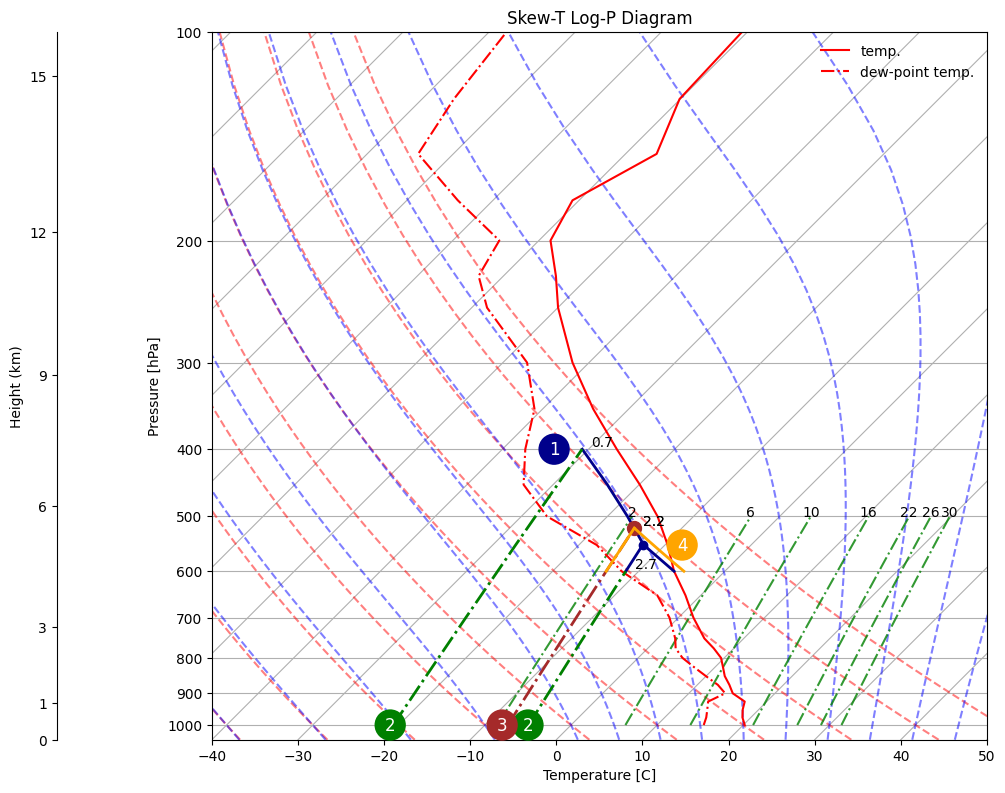

In [328]:
# Make the plot
skew = plot_basic_skewt()

# Plot sounding
skew.plot(ds.pressure_level, ds.t-273.15, c='red', label='temp.')
skew.plot(ds.pressure_level, ds.tdew-273.65, c='red', linestyle='-.', label='dew-point temp.')
skew.ax.legend(frameon=False)

p0 = 600
pe = 400

dspl = ds.sel(pressure_level=slice(p0,pe))

# Lift parcel adiabatically from lowest to highest level in dspl
tprof = mpcalc.parcel_profile(dspl.pressure_level * units('hPa'), 
                              dspl.t[0].values * units('K'),
                              dspl.tdew[0].values * units('K')).metpy.convert_units('degC')
plcl, tlcl = mpcalc.lcl(dspl.pressure_level[0] * units('hPa'),
                        dspl.t[0].values * units('K'),
                        dspl.tdew[0].values * units('K'))

dewpoint = (dspl.tdew * units('K')).metpy.convert_units('degC') # Convert to °C
e = mpcalc.saturation_vapor_pressure(dewpoint)
mixing_ratio = mpcalc.mixing_ratio(e, dspl.pressure_level * units('hPa'))

isohume = []
pisohume = np.linspace(dspl.pressure_level[0].values * units('hPa'), plcl, 5)
for p in pisohume:
    isohume.append(mpcalc.dewpoint(mpcalc.vapor_pressure(p, mixing_ratio[0])).metpy.convert_units('degC'))  # Convert to °C

# Plot parcel
skew.plot(dspl.pressure_level, tprof, c='darkblue', linewidth=2)
skew.plot(pisohume, isohume, c='darkblue', linewidth=2)
skew.plot(plcl, tlcl.to('degC'), 'o', c='darkblue')

# Now add an isohumes to top and bottom level of the rising parcel, and to the new LCL point
# Isohume going from 1000 hPa through a prescribed combination of T and p
# These must have units degC and hPa
def isohume(t, p, skew, p0=1000, c='green', linestyle='-.'):
    e = mpcalc.saturation_vapor_pressure(t)
    mixing_ratio = mpcalc.mixing_ratio(e, p)
    pisohume = np.linspace(p0 * units('hPa'), p, 5)
    isohume = np.zeros(pisohume.size) * units('degC')
    for i in range(len(pisohume)):
        isohume[i] = mpcalc.dewpoint(mpcalc.vapor_pressure(pisohume[i], mixing_ratio))
    skew.plot(pisohume, isohume, c=c, linestyle=linestyle, linewidth=2)
    skew.ax.text(t.magnitude+1, p, f"{mixing_ratio.to('g/kg').magnitude:.1f}", color='black', fontsize=10, verticalalignment='bottom')

isohume(dewpoint[0].values * units('degC'), p0 * units('hPa'), skew)
isohume(tprof[-1].values * units('degC'), pe * units('hPa'), skew)

# T and p combo that matches the rainfall calculation in the text
tlcl2 = -15.5 * units('degC')
plcl2 = 520 * units('hPa')
isohume(tlcl2, plcl2, skew, c='brown')

# dry adiabat down to p0
pressures = np.linspace(p0 * units('hPa'), plcl2, 5)
ts = mpcalc.dry_lapse(pressures, tlcl2, reference_pressure=plcl2).to('degC')

# Plot new parcel
plt.plot(tlcl2, plcl2, 'o', c='brown', markersize=10)
skew.plot(pressures, ts, c='orange', linewidth=2)
isohume(tlcl2, plcl2, skew, p0=p0, c='orange', linestyle='-')

plt.text(-34, 400, '1', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='darkblue', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-21, 1000, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='green', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-5, 1000, '2', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='green', edgecolor='none', boxstyle='circle', pad=0.4))
plt.text(-8, 1000, '3', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='brown', edgecolor='none', boxstyle='circle', pad=0.4))
_=plt.text(-8, 550, '4', fontsize=12, color='white', ha='center', va='center',
         bbox=dict(facecolor='orange', edgecolor='none', boxstyle='circle', pad=0.4))
